# Marktstammdatenregister
https://www.marktstammdatenregister.de/MaStR/Datendownload

In [2]:
import os
import re
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [28]:
# params
dir = 'data/Marktstammdatenregister'

solar = 'EinheitenSolar'
wind = 'EinheitenWind'

get_dataframes = True

solar_attributes = ['EinheitMastrNummer',
                    'EinheitBetriebsstatus', 
                    'Postleitzahl',
                    'Inbetriebnahmedatum',
                    'DatumEndgueltigeStilllegung',
                    'Breitengrad',
                    'Laengengrad',
                    'Nettonennleistung',
                    'AnzahlModule',
                    'Hauptausrichtung',
                    'HauptausrichtungNeigungswinkel']

wind_attributes = ['EinheitMastrNummer',
                   'EinheitBetriebsstatus',
                   'Postleitzahl',
                   'Inbetriebnahmedatum',
                   'DatumEndgueltigeStilllegung',
                   'Breitengrad',
                   'Laengengrad',
                   'Nettonennleistung',
                   'Nabenhoehe',
                   'Rotordurchmesser',
                   'NameWindpark',
                   'Hersteller',
                   'Technologie',
                   'Typenbezeichnung',
                   'Kuestenentfernung']

In [29]:
def extract_sort_key(filepath):
    match = re.search(r'/(.+?)_(\d+)\.xml$', filepath)
    if match:
        category = match.group(1)
        number = int(match.group(2)) 
    else:
        category = filepath.split('/')[-1]
        number = float('inf')
    return category, number

def get_list(dir, feature):
    file_names = os.listdir(dir)
    paths = [os.path.join(dir, file) for file in file_names]
    paths = [path for path in paths if feature in path]
    paths = sorted(paths, key=extract_sort_key)
    return paths

def read_xml(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        print(f"XML-Datei erfolgreich eingelesen: {file_path}")
        return root
    except ET.ParseError as e:
        print(f"Fehler beim Einlesen der XML-Datei: {e}")
        return None
    except FileNotFoundError:
        print(f"Datei nicht gefunden: {file_path}")
        return None
    
def xml_to_df(paths: list,
              attributes: list) -> pd.DataFrame:
    data = []
    for path in paths:
        root = read_xml(path)
        for ele in root:
            row = {k: None for k in attributes}
            for attr in ele:
                if attr.tag in attributes:
                    row[attr.tag] = attr.text
            data.append(row)
    df = pd.DataFrame(data=data, columns=attributes)
    return df

In [30]:
if get_dataframes:
    solar_paths = get_list(dir, solar)
    wind_paths = get_list(dir, wind)

    df_solar = xml_to_df(paths=solar_paths,
                        attributes=solar_attributes)

    df_wind = xml_to_df(paths=wind_paths, 
                        attributes=wind_attributes)

    df_solar.to_csv(os.path.join(dir, 'Solar_MaStR.csv'), index=False)
    df_wind.to_csv(os.path.join(dir, 'Wind_MaStR.csv'), index=False)

XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_1.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_2.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_3.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_4.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_5.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_6.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_7.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_8.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_9.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_10.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSolar_11.xml
XML-Datei erfolgreich eingelesen: data/Marktstammdatenregister/EinheitenSo

In [52]:
df_solar = pd.read_csv(os.path.join(dir, 'Solar_MaStR.csv'))
df_wind = pd.read_csv(os.path.join(dir, 'Wind_MaStR.csv'))

df_solar['Inbetriebnahmedatum'] = pd.to_datetime(df_solar['Inbetriebnahmedatum'])
df_wind['Inbetriebnahmedatum'] = pd.to_datetime(df_wind['Inbetriebnahmedatum'])
df_wind['DatumEndgueltigeStilllegung'] = pd.to_datetime(df_wind['DatumEndgueltigeStilllegung'])
df_solar['DatumEndgueltigeStilllegung'] = pd.to_datetime(df_solar['DatumEndgueltigeStilllegung'])

/tmp/ipykernel_615631/1594805909.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_solar = pd.read_csv(os.path.join(dir, 'Solar_MaStR.csv'))


In [53]:
def plot_distribution(series: pd.Series,
                      x_label: str = '',
                      bins: int = 20):
    sns.histplot(data=series, kde=True, stat='probability', bins=bins)
    plt.xlabel(x_label)
    plt.show()

def exclude_outliers(series: pd.Series,
                     q_high: float = 0.99,
                     q_low: float = 0.0) -> pd.Series:
    q_high = series.quantile(q_high)
    q_low = series.quantile(q_low)
    mask = (series < q_high) & (series > q_low)
    return series[mask]

def get_lifetime(data: pd.DataFrame) -> pd.Series:
    deactivated = data[~data['DatumEndgueltigeStilllegung'].isna()]
    lifetime = deactivated['DatumEndgueltigeStilllegung'] - deactivated['Inbetriebnahmedatum']
    lifetime = lifetime.dt.days / 365
    return lifetime

def get_age(data: pd.DataFrame,
            q_high: float = 1) -> pd.Series:
    age = datetime.now() - data['Inbetriebnahmedatum']
    age = age.dt.days / 365
    age = exclude_outliers(series=age, q_high=q_high)
    return age

def plot_without_outliers(series: pd.Series,
                          x_label: str = '',
                          bins: int = 20,
                          q_high: float = 0.99,
                          q_low: float = 0.0):
    series = exclude_outliers(series=series, q_high=q_high, q_low=q_low)
    plot_distribution(series=series, 
                      x_label=x_label,
                      bins=bins)
    
def auto_plot_without_outliers(data: pd.DataFrame,
                               features: list,
                               bins: int = 20,
                               q_high: float = 0.99,
                               q_low: float = 0.0):
    for feature in features:
        series = data[feature]
        if (series.dtype != 'float64') & (series.dtype != 'int64'):
            continue
        series = exclude_outliers(series=series, q_high=q_high, q_low=q_low)
        plot_distribution(series=series, 
                        x_label=feature,
                        bins=bins)

## Solar Analysis

In [54]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4869174 entries, 0 to 4869173
Data columns (total 11 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   EinheitMastrNummer              object        
 1   EinheitBetriebsstatus           int64         
 2   Postleitzahl                    object        
 3   Inbetriebnahmedatum             datetime64[ns]
 4   DatumEndgueltigeStilllegung     datetime64[ns]
 5   Breitengrad                     float64       
 6   Laengengrad                     float64       
 7   Nettonennleistung               float64       
 8   AnzahlModule                    float64       
 9   Hauptausrichtung                float64       
 10  HauptausrichtungNeigungswinkel  float64       
dtypes: datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 408.6+ MB


Drop rows with launch dates before 1985.

In [55]:
df_solar.drop(df_solar[df_solar['Inbetriebnahmedatum'] < '1985-01-01'].index, inplace=True)

Duration of operation

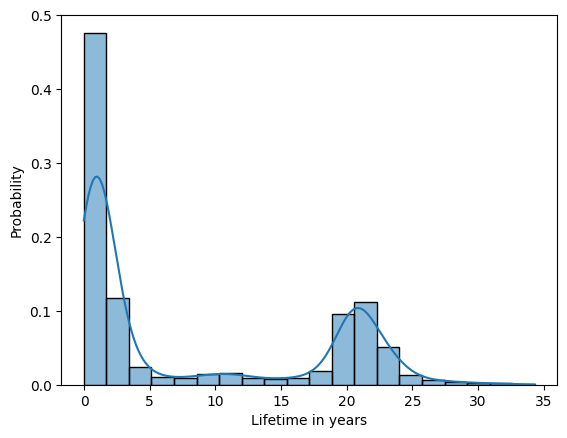

In [56]:
lifetime = get_lifetime(data=df_solar)
plot_distribution(series=lifetime, 
                  x_label='Lifetime in years', 
                  bins=20)

Exclude the closed systems.

In [57]:
df_solar.drop(df_solar[df_solar['EinheitBetriebsstatus'] != 35].index, inplace=True)

### Age of the system

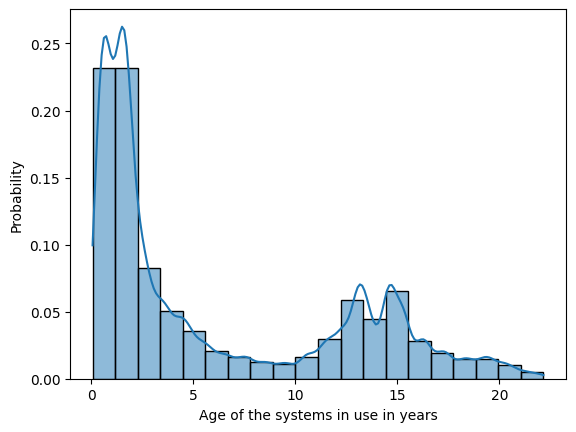

In [58]:
age = get_age(data=df_solar, q_high=0.99)
plot_distribution(series=age, 
                  x_label='Age of the systems in use in years',
                  bins=20)

## Plot distribution of all the other features

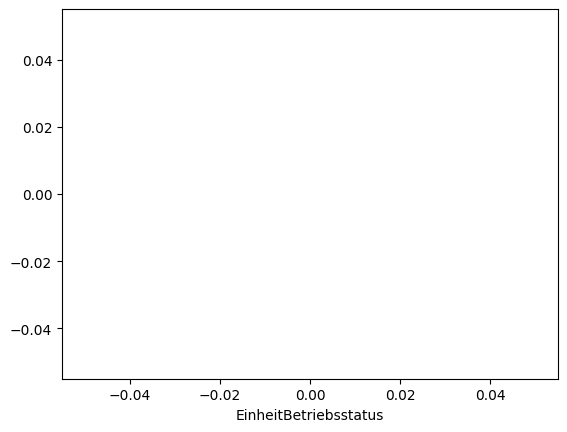

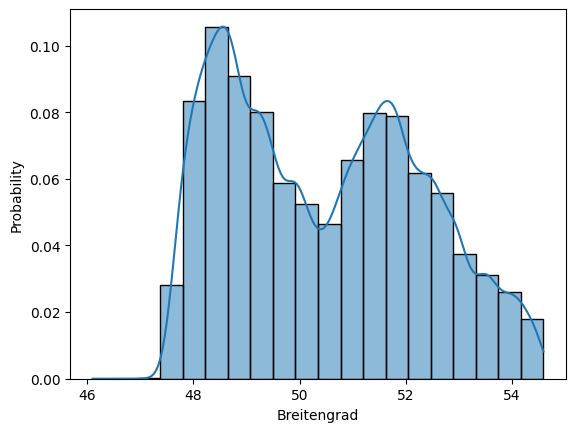

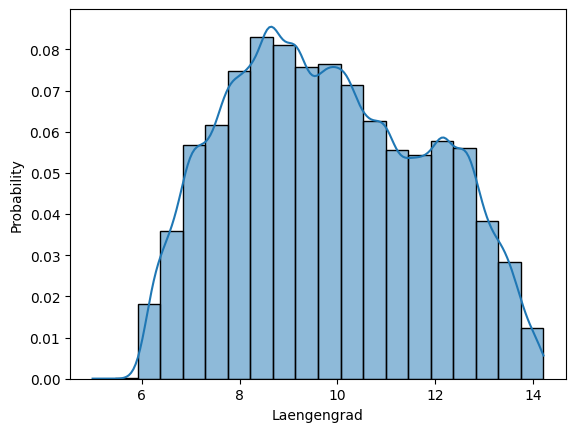

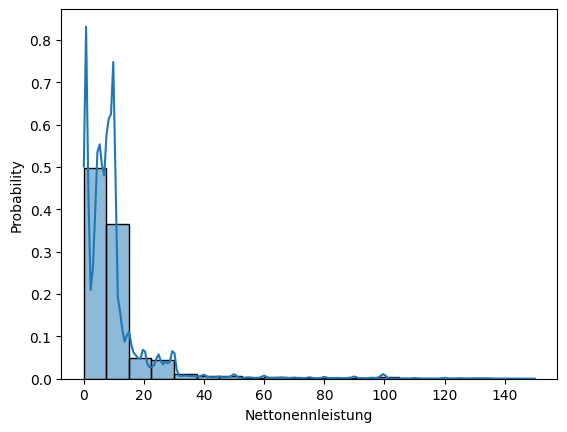

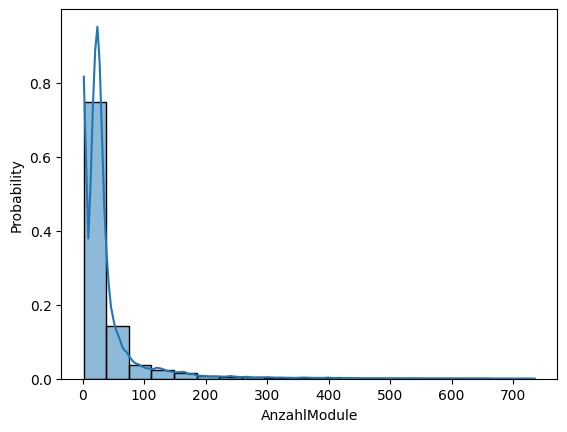

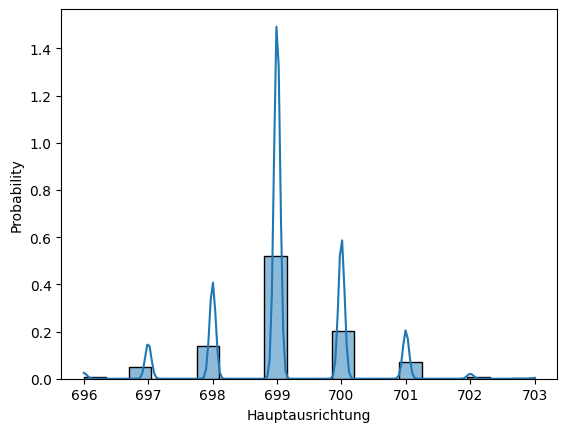

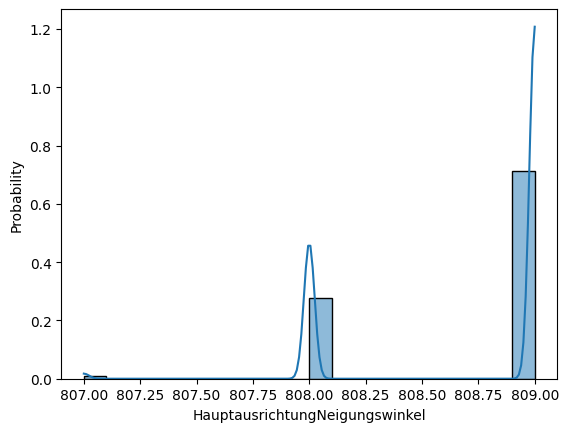

In [59]:
auto_plot_without_outliers(data=df_solar,
                           features=solar_attributes,
                           bins=20,
                           q_high=0.99,
                           q_low=0)

## Wind Analysis

In [60]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38075 entries, 0 to 38074
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   EinheitMastrNummer           38075 non-null  object        
 1   EinheitBetriebsstatus        38075 non-null  int64         
 2   Postleitzahl                 36285 non-null  float64       
 3   Inbetriebnahmedatum          33371 non-null  datetime64[ns]
 4   DatumEndgueltigeStilllegung  1936 non-null   datetime64[ns]
 5   Breitengrad                  36983 non-null  float64       
 6   Laengengrad                  36983 non-null  float64       
 7   Nettonennleistung            38075 non-null  float64       
 8   Nabenhoehe                   37168 non-null  float64       
 9   Rotordurchmesser             37599 non-null  float64       
 10  NameWindpark                 37205 non-null  object        
 11  Hersteller                   37603 non-nu

Duration of operation

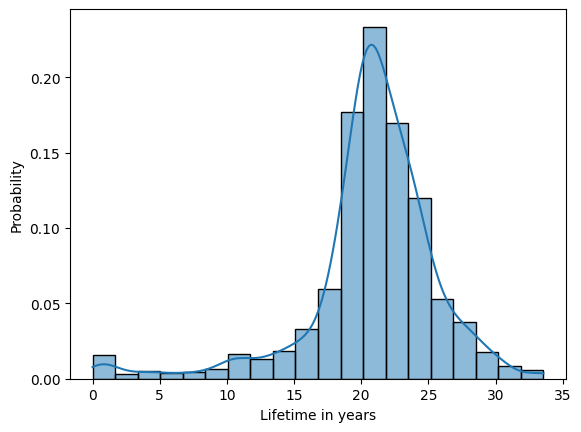

In [61]:
lifetime = get_lifetime(data=df_wind)
plot_distribution(series=lifetime, 
                  x_label='Lifetime in years', 
                  bins=20)

Exclude the closed systems.

In [62]:
df_wind.drop(df_wind[df_wind['EinheitBetriebsstatus'] != 35].index, inplace=True)

## Age

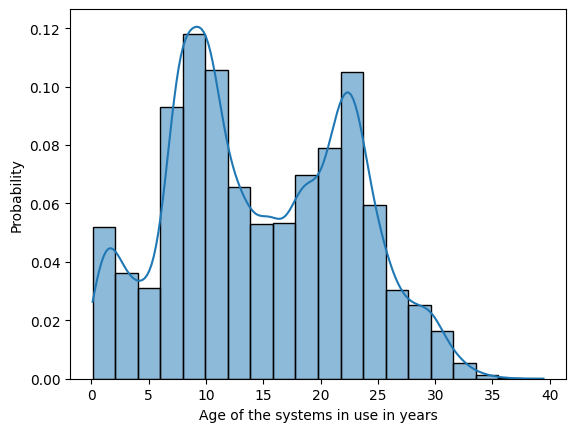

In [63]:
age = get_age(data=df_wind, q_high=1)
plot_distribution(series=age, 
                  x_label='Age of the systems in use in years',
                  bins=20)

### Plot all the other distributions

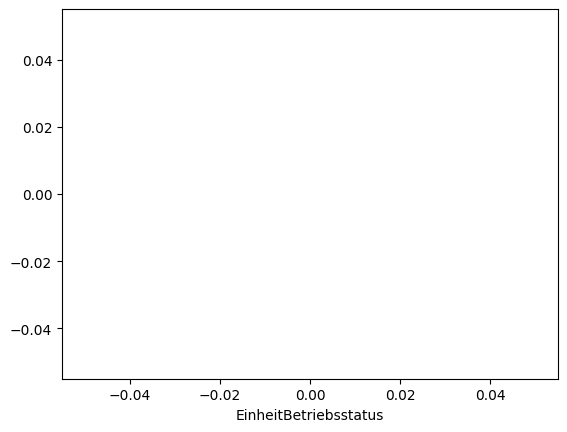

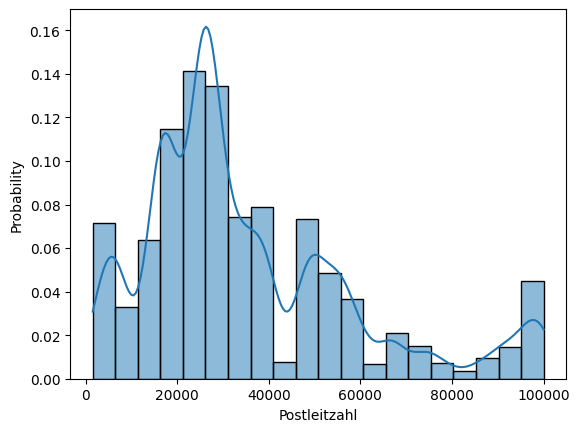

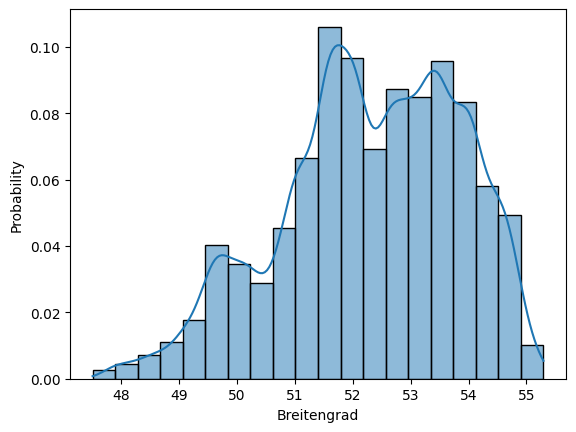

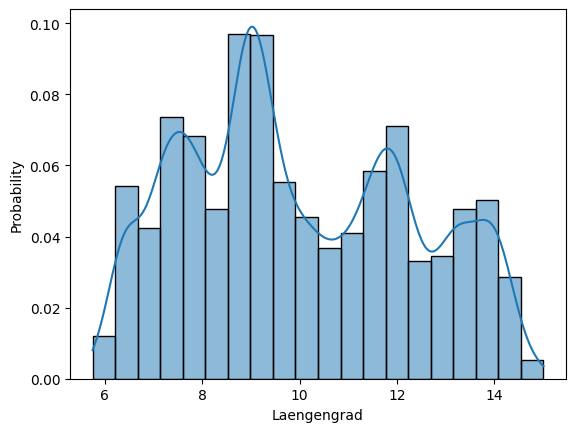

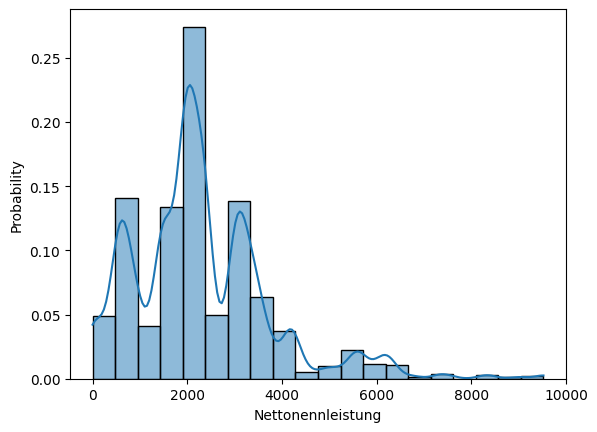

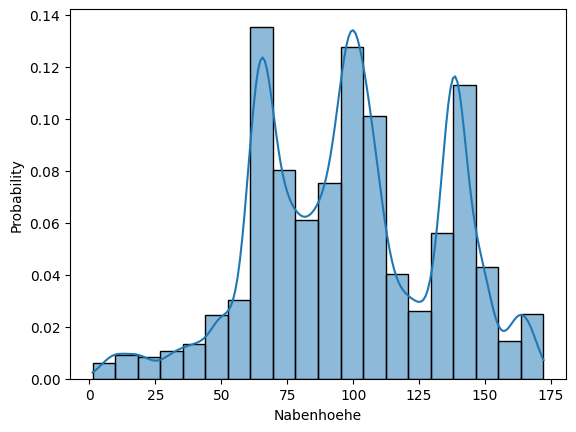

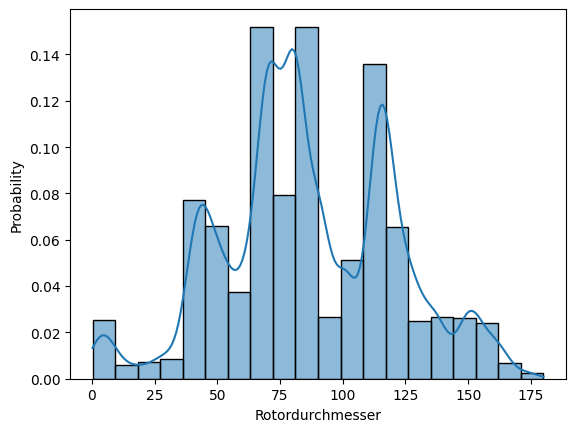

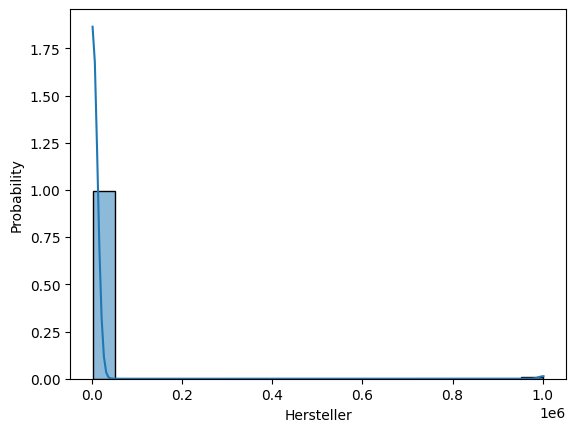

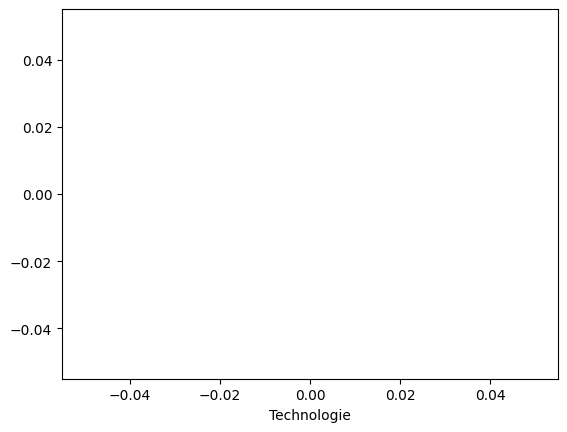

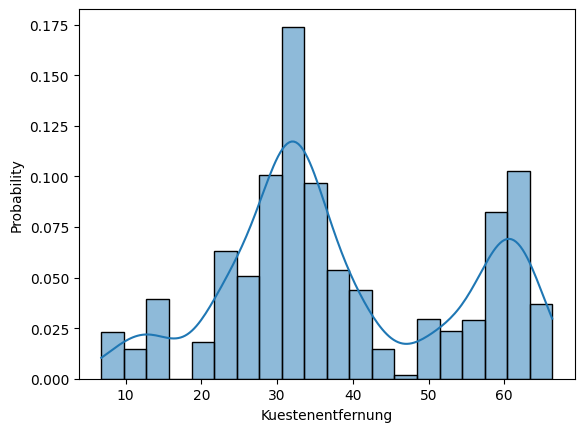

In [64]:
auto_plot_without_outliers(data=df_wind,
                           features=wind_attributes,
                           bins=20,
                           q_high=1,
                           q_low=0)

In [67]:
df_wind.Typenbezeichnung.value_counts()[:25]

Typenbezeichnung
E-70 E4         905
E-82 E2         626
E-115           603
E-101           585
E-82            555
V90             492
V80             359
V112            355
SWT-3.6-120     352
E82             258
N117            256
E-53            250
E-40            248
E-66/18.70      232
E-92            219
V126            203
E-70            200
E-40/6.44       197
E-66/18.70-3    195
E40             195
E-66            192
MD77            174
E-138 EP3 E2    171
SWT-6.0-154     164
3.2M114         160
Name: count, dtype: int64